In [36]:
import csv

import requests
from dagster_dask import dask_executor
from dagster import get_dagster_logger, job, op, Out
from dagster import fs_io_manager

import numpy as np

import itkConfig
itkConfig.LazyLoading = False

import itk
import vtk
from itkwidgets import view
import icon_registration.itk_wrapper as itk_wrapper
import icon_registration.pretrained_models as pretrained_models
import matplotlib.pyplot as plt

import sys
sys.path.append("/data/OAI_analysis_2/oai_analysis_2")

import mesh_processing as mp
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""

from dask import delayed, compute, visualize
from skimage import measure

In [37]:
from dask.distributed import Client, progress

import pickle

def pickle_dumps(x):
    header = {'serializer': 'pickle'}
    frames = [pickle.dumps(x)]
    return header, frames

def pickle_loads(header, frames):
    if len(frames) > 1:  # this may be cut up for network reasons
        frame = ''.join(frames)
    else:
        frame = frames[0]
    return pickle.loads(frame)

from distributed.protocol.serialize import register_serialization_family
register_serialization_family('pickle', pickle_dumps, pickle_loads)


client = Client(n_workers=1, 
                serializers=['pickle', 'dask',],
                deserializers=['pickle', 'dask'])
client

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33601 instead


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:33601/status,
Dashboard: http://127.0.0.1:33601/status,Workers: 1
Total threads: 16,Total memory: 125.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46679,Workers: 1
Dashboard: http://127.0.0.1:33601/status,Total threads: 16
Started: Just now,Total memory: 125.73 GiB
Comm: tcp://127.0.0.1:44193,Total threads: 16
Dashboard: http://127.0.0.1:39521/status,Memory: 125.73 GiB
Nanny: tcp://127.0.0.1:40519,


In [58]:
# All Function Definitions

def download_data():
    os.system('girder-client --api-url https://data.kitware.com/api/v1 localsync 621a5d784acac99f426c143b OAIData')
    
    get_dagster_logger().info('Data download done')

    image_preprocessed = "./OAIData/atlas_image.nii.gz"
    atlas_image = "./OAIData/atlas_image.nii.gz"
    return image_preprocessed, atlas_image

@delayed(nout=2)
def read_images(image_preprocessed, atlas_image):
    image_A = itk.imread(image_preprocessed, itk.D)
    image_B = itk.imread(atlas_image, itk.D)
    return image_A, image_B

def register_images(image_A, image_B):
    model = pretrained_models.OAI_knees_registration_model()
    model.to('cpu')

    # Register the images
    phi_AB, phi_BA = itk_wrapper.register_pair(model, image_A, image_B)
    
    return phi_AB

def deform_probmap(phi_AB, image_A, image_B):
    fc_prob_file = '/data/OAI_analysis_2/OAIData/FC_probmap.nii.gz'
    tc_prob_file = '/data/OAI_analysis_2/OAIData/TC_probmap.nii.gz'

    FC_prob = itk.imread(fc_prob_file)
    TC_prob = itk.imread(tc_prob_file)

#     interpolator = itk.LinearInterpolateImageFunction.New(image_A)
#     warped_image_FC = itk.resample_image_filter(FC_prob, 
#         transform=phi_AB, 
#         interpolator=interpolator,
#         size=itk.size(image_B),
#         output_spacing=itk.spacing(image_B),
#         output_direction=image_B.GetDirection(),
#         output_origin=image_B.GetOrigin()
#     )

#     warped_image_TC = itk.resample_image_filter(TC_prob, 
#         transform=phi_AB, 
#         interpolator=interpolator,
#         size=itk.size(image_B),
#         output_spacing=itk.spacing(image_B),
#         output_direction=image_B.GetDirection(),
#         output_origin=image_B.GetOrigin()
#     )
    return FC_prob, TC_prob
    #return warped_image_FC, warped_image_TC

@delayed
def get_faces(itk_image):
    spacing = itk_image.GetSpacing()
    itk_image_array = np.asarray(itk_image)
    img_array = np.swapaxes(itk_image_array, 0, 2).astype(float)
    
    from skimage import measure
    # Obtain the mesh from Probability maps using Marching Cubes
    verts, faces, normals, values = measure.marching_cubes_lewiner(img_array, 0.5,
                                                                    spacing=spacing,
                                                                    step_size=1, 
                                                                    gradient_direction="ascent")
    
    mesh = mp.get_vtk_mesh(verts, faces)

    # For smoothing the mesh surface to obtain gradually varying face normals
    mesh = mp.smooth_mesh(mesh, num_iterations=150)
    
    itk_mesh = get_itk_mesh(mesh)
    
    return itk_mesh
    
def get_itk_mesh(vtk_mesh):
    Dimension = 3
    PixelType = itk.D
    
    MeshType = itk.Mesh[PixelType, Dimension]
    itk_mesh = MeshType.New()
    
    # Get points array from VTK mesh
    points = vtk_mesh.GetPoints().GetData()
    points_numpy = np.array(points).flatten().astype('float32')
        
    polys = vtk_mesh.GetPolys().GetData()
    polys_numpy = np.array(polys).flatten()

    # Triangle Mesh
    vtk_cells_count = vtk_mesh.GetNumberOfPolys()
    polys_numpy = np.reshape(polys_numpy, [vtk_cells_count, Dimension+1])

    # Extracting only the points by removing first column that denotes the VTK cell type
    polys_numpy = polys_numpy[:, 1:]
    polys_numpy = polys_numpy.flatten().astype(np.uint64)

    # Get point data from VTK mesh to insert in ITK Mesh
#     point_data_numpy = np.array(vtk_mesh.GetPointData().GetScalars()).astype('float64')
#     print(point_data_numpy.shape, point_data_numpy.dtype)
#     print(point_data_numpy)
    
#     # Get cell data from VTK mesh to insert in ITK Mesh
#     cell_data_numpy = np.array(vtk_mesh.GetCellData().GetScalars()).astype('float64')
#     print(cell_data_numpy.shape, cell_data_numpy.dtype)
    
    print(itk.vector_container_from_array(points_numpy))
    itk_mesh.SetPoints(itk.vector_container_from_array(points_numpy))
    itk_mesh.SetCellsArray(itk.vector_container_from_array(polys_numpy), itk.CommonEnums.CellGeometry_TRIANGLE_CELL)
    #itk_mesh.SetPointData(itk.vector_container_from_array(point_data_numpy))
    #itk_mesh.SetCellData(itk.vector_container_from_array(cell_data_numpy))    
    return itk_mesh

@delayed(nout=2)
def get_thickness_dask(image, mesh_type):
    inner_FC, outer_FC = mp.get_thickness_mesh(image, mesh_type=mesh_type, num_iterations=150)
    
    #inner_FC_itk_mesh = get_itk_mesh(inner_FC)
    #outer_FC_itk_mesh = get_itk_mesh(outer_FC)
    #return inner_FC_itk_mesh, outer_FC_itk_mesh
    
    return inner_FC, outer_FC
    
@delayed(nout=2)
def get_thickness(warped_image_FC, warped_image_TC):
    distance_inner_FC, distance_outer_FC = mp.get_thickness_mesh(warped_image_FC, mesh_type='FC')
    distance_inner_TC, distance_outer_TC = mp.get_thickness_mesh(warped_image_TC, mesh_type='TC')
    
    return distance_inner_FC, distance_inner_TC

@delayed(nout=2)
def get_paths():
    image_preprocessed = "/data/OAI_analysis_2/OAIData/atlas_image.nii.gz"
    atlas_image = "/data/OAI_analysis_2/OAIData/atlas_image.nii.gz"

    return image_preprocessed, atlas_image

@delayed(nout=2)
def register_and_deform(image_A, image_B):
    phi_AB                               = register_images(image_A=image_A, image_B=image_B)
    warped_image_FC, warped_image_TC     = deform_probmap(phi_AB=phi_AB, image_A=image_A, image_B=image_B)
    return warped_image_FC, warped_image_TC

@delayed
def entire_job(warped_image_FC, warped_image_TC):
    distance_inner_FC, distance_inner_TC = get_thickness(warped_image_FC=warped_image_FC, warped_image_TC=warped_image_TC)

    writer1 = vtk.vtkPolyDataWriter()
    writer1.SetFileName('distance_inner_FC.vtk')
    writer1.SetInputData(distance_inner_FC)
    writer1.Update()

    writer2 = vtk.vtkPolyDataWriter()
    writer2.SetFileName('distance_inner_TC.vtk')
    writer2.SetInputData(distance_inner_TC)
    writer2.Update()

@delayed
def thickness_compute():
    #image_preprocessed, atlas_image = download_data()
    #image_preprocessed = "./OAIData/atlas_image.nii.gz"
    #atlas_image = "./OAIData/atlas_image.nii.gz"

    #image_preprocessed, atlas_image =  get_paths()
    
    # In ITKrc3 images can be serialized
    image_preprocessed, atlas_image   = get_paths()
    image_A, image_B                  = read_images(image_preprocessed, atlas_image)
    warped_image_FC, warped_image_TC  = register_and_deform(image_A, image_B)
    
    distance_inner_FC, distance_outer_FC = mp.get_thickness_mesh(warped_image_FC, mesh_type='FC')
    distance_inner_TC, distance_outer_TC = mp.get_thickness_mesh(warped_image_TC, mesh_type='TC')
    
    return distance_inner_FC, distance_inner_TC
    # Rest all the processing is done here
    # After mesh serialization this can be splitted into smaller components
    # Also working on Transform serialization
    #entire_job(warped_image_FC, warped_image_TC)

In [59]:
image_preprocessed, atlas_image   = get_paths()

image_A, image_B                  = read_images(image_preprocessed, atlas_image)
warped_image_FC, warped_image_TC  = register_and_deform(image_A, image_B)

test_mesh = get_faces(warped_image_FC)
#phi_AB                               = register_images(image_A=image_A, image_B=image_B)

# distance_inner_FC, distance_outer_FC = get_thickness_dask(warped_image_FC, mesh_type='FC')
# distance_inner_TC, distance_outer_TC = get_thickness_dask(warped_image_TC, mesh_type='TC')

# all_distance = [distance_inner_FC, distance_inner_TC]

In [6]:
itk.meshwrite(distance_inner_FC, 'itk_distance_inner_FC.vtk')
itk.meshwrite(distance_inner_TC, 'itk_distance_inner_TC.vtk')

**Note:** Don't do `delayed(inc(i))`

In [9]:
import itkwidgets

In [7]:
a1 = vtk.vtkPolyDataReader()
a1.SetFileName('/home/pranjal.sahu/OAI/OAI_analysis/coiled-resources/dask-delayed/itk_distance_inner_FC.vtk')
a1.Update()
a1 = a1.GetOutput()

#a1.SetFileName('/home/pranjal.sahu/OAI/OAI_analysis/coiled-resources/dask-delayed/itk_distance_inner_FC.vtk')

In [ ]:
itkwidgets.view(geometries=[a1])

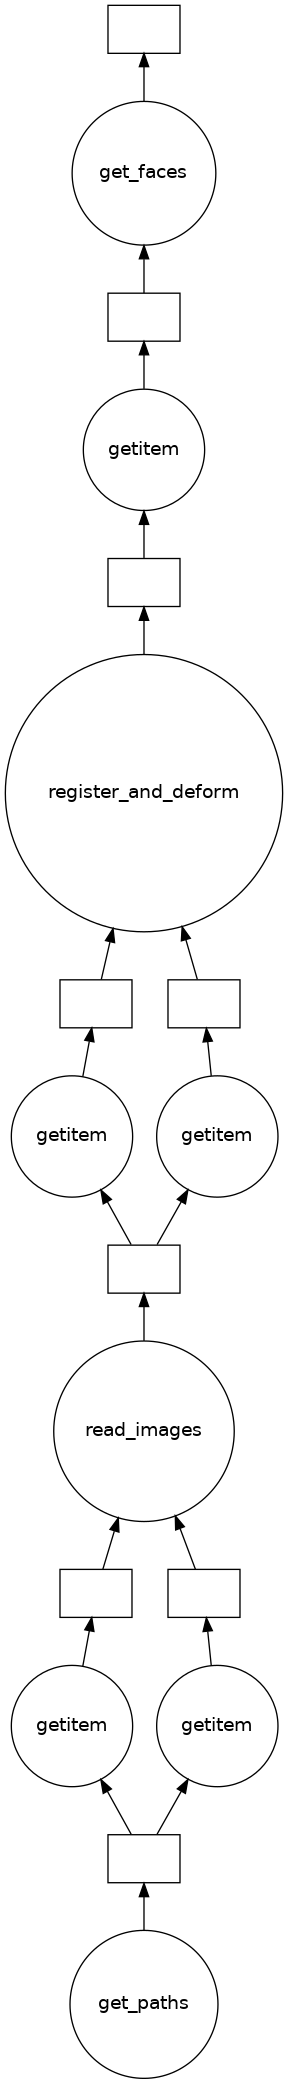

In [60]:
visualize(test_mesh)

**Note:** Try to minimize computing.

In [61]:
%%time

l = compute(test_mesh)

CPU times: user 601 ms, sys: 211 ms, total: 812 ms
Wall time: 29.5 s


In [63]:
print(l[0])

Mesh (0x7fe190001430)
  RTTI typeinfo:   itk::Mesh<double, 3u, itk::DefaultStaticMeshTraits<double, 3u, 3u, float, float, double> >
  Reference Count: 1
  Modified Time: 10627446
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 0
  UpdateMTime: 0
  RealTimeStamp: 0 seconds 
  Number Of Points: 122819
  Requested Number Of Regions: 0
  Requested Region: -1
  Buffered Region: -1
  Maximum Number Of Regions: 1
  Point Data Container pointer: 0x7fe190001c10
  Size of Point Data Container: 0
  Number Of Points: 122819
  Number Of Cell Links: 0
  Number Of Cells: 243182
  Cell Data Container pointer: 0x7fe19155fe40
  Size of Cell Data Container: 0
  Number of explicit cell boundary assignments: 3
  CellsAllocationMethod: itk::MeshEnums::MeshClassCellsAllocationMethod::CellsAllocatedDynamicallyCellByCell



In [25]:
print(l[0][0].shape, l[0][1].shape, l[0][2].shape)

(122819, 3) (245618, 3) (122819, 3)


In [11]:
l[0].shape

(160, 384, 384)

In [14]:
import pickle 
print(pickle.format_version)

4.0


In [11]:
a = itk.Mesh[itk.D, 3].New()
#print(a)
b = pickle.loads(pickle.dumps(a))

In [13]:
print(b)

Mesh (0x55e54fa6bee0)
  RTTI typeinfo:   itk::Mesh<double, 3u, itk::DefaultStaticMeshTraits<double, 3u, 3u, float, float, double> >
  Reference Count: 1
  Modified Time: 165
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 0
  UpdateMTime: 0
  RealTimeStamp: 0 seconds 
  Number Of Points: 0
  Requested Number Of Regions: 0
  Requested Region: -1
  Buffered Region: -1
  Maximum Number Of Regions: 1
  Point Data Container pointer: 0x55e550e972e0
  Size of Point Data Container: 0
  Number Of Points: 0
  Number Of Cell Links: 0
  Number Of Cells: 0
  Cell Data Container pointer: 0x55e5505b9810
  Size of Cell Data Container: 0
  Number of explicit cell boundary assignments: 3
  CellsAllocationMethod: itk::MeshEnums::MeshClassCellsAllocationMethod::CellsAllocatedDynamicallyCellByCell



In [12]:
print(a)

Mesh (0x55e550403cc0)
  RTTI typeinfo:   itk::Mesh<double, 3u, itk::DefaultStaticMeshTraits<double, 3u, 3u, float, float, double> >
  Reference Count: 1
  Modified Time: 152
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 0
  UpdateMTime: 0
  RealTimeStamp: 0 seconds 
  Number Of Points: 0
  Requested Number Of Regions: 0
  Requested Region: -1
  Buffered Region: -1
  Maximum Number Of Regions: 1
  Point Data Container pointer: 0x55e550018760
  Size of Point Data Container: 0
  Number Of Points: 0
  Number Of Cell Links: 0
  Number Of Cells: 0
  Cell Data Container pointer: 0x55e55024c300
  Size of Cell Data Container: 0
  Number of explicit cell boundary assignments: 3
  CellsAllocationMethod: itk::MeshEnums::MeshClassCellsAllocationMethod::CellsAllocatedDynamicallyCellByCell

